In [1]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from itertools import product
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from datasets import get_real_dataset

from rf_fourier.fourier import Fourier
from rf_fourier.rf_fourier_extractor import RFFourierExtractor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

random_seed = 1
torch.manual_seed(random_seed)
random.seed(random_seed)

data_directory = os.environ.get("EXPERIMENT_DATA") if "EXPERIMENT_DATA" in os.environ else os.getcwd()

# Load dataset

In [2]:
dataset_name = "SGEMM"
train_size = 10000
rf_n_estimators = 100
rf_max_depth = 10

model_name = f"{dataset_name}_train{train_size}_nest{rf_n_estimators}_depth{rf_max_depth}_seed{random_seed}"
fourier_file = f"{data_directory}/rf_fourier/{model_name}.pkl"
rf_file = f"{data_directory}/rf_model/{model_name}.pkl"

dataset = get_real_dataset(dataset_name)
dataset.y = (dataset.y-torch.mean(dataset.y))/torch.std(dataset.y)
total_size = len(dataset)
torch.manual_seed(random_seed)
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, total_size - train_size])
print(len(train_ds), len(val_ds))

Loaded dataset from cache.
10000 231600


# Train RF

In [3]:
model =  RandomForestRegressor(n_estimators=rf_n_estimators, max_depth=rf_max_depth, random_state=random_seed)

if not os.path.exists(rf_file):
    model.fit(train_ds[:][0].cpu().numpy(), train_ds[:][1].cpu().numpy())
    with open(rf_file, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(rf_file, 'rb') as handle:
        model = pickle.load(handle)


train_pred = model.predict(train_ds[:][0].cpu().numpy())
val_pred = model.predict(val_ds[:][0].cpu().numpy())
# test_pred = model.predict(test_ds[:][0].cpu().numpy())

log = {
        "train_mse_loss": mean_squared_error(train_ds[:][1].cpu().numpy(), train_pred),
        "train_r2": r2_score(train_ds[:][1].cpu().numpy(), train_pred),
        "val_mse_loss": mean_squared_error(val_ds[:][1].cpu().numpy(), val_pred),
        "val_r2": r2_score(val_ds[:][1].cpu().numpy(), val_pred),
        # "test_mse_loss": mean_squared_error(test_ds[:][1].cpu().numpy(), test_pred),
        # "test_r2": r2_score(test_ds[:][1].cpu().numpy(), test_pred),
    }

print(log)

{'train_mse_loss': 0.002871174176531081, 'train_r2': 0.9973357569395795, 'val_mse_loss': 0.005646830939298296, 'val_r2': 0.994334073963072}


In [4]:
for est in model.estimators_:
    tree = est.tree_
    print(np.sum(np.array(tree.children_left) != -1))

982
974
956
954
963
968
975
954
973
965
965
963
984
979
974
950
941
965
964
904
977
970
969
966
967
988
971
952
972
962
961
971
956
966
977
979
966
971
968
972
966
956
983
960
966
970
994
969
974
984
983
956
949
961
975
967
965
982
963
973
962
978
976
972
958
977
977
970
978
985
971
975
960
958
980
966
968
974
970
971
961
982
982
970
978
969
952
966
969
966
960
978
964
935
971
977
969
978
966
981


# Extract Fourier

In [5]:
if not os.path.exists(fourier_file):
    rf_fourier = RFFourierExtractor(model).get_fourier_transform()

    with open(fourier_file, 'wb') as handle:
        pickle.dump(rf_fourier, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(fourier_file, 'rb') as handle:
        rf_fourier = pickle.load(handle)
    print("Sparsity =", len(rf_fourier.series))

100%|██████████| 100/100 [02:31<00:00,  1.51s/it]


Sparsity = 2357592


In [7]:
rf_fourier2 = RFFourierExtractor(model).get_fourier_transform()

In [10]:
rf_fourier = Fourier(rf_fourier2.series, tolerance=1e-5)
train_fourier_preds = rf_fourier.predict(train_ds[:][0].cpu().numpy())
val_fourier_preds = rf_fourier.predict(val_ds[:][0].cpu().numpy())


fourier_log = {
        "train_r2": r2_score(train_ds[:][1].cpu().numpy(), train_fourier_preds),
        "val_r2": r2_score(val_ds[:][1].cpu().numpy(), val_fourier_preds),
        "train_fourier_r2": r2_score(train_pred, train_fourier_preds),
        "val_fourier_r2": r2_score(val_pred, val_fourier_preds),
    }

print(fourier_log)

2956


KeyboardInterrupt: 

# Ablation Experiment

In [225]:
fourier_seris = rf_fourier.series

deg_list = np.array([(len(f), f) for f in fourier_seris.keys()])
amp_list = np.array(list(fourier_seris.values()))
argsort_freq = np.argsort(np.abs(amp_list))
argsort_deg = np.argsort([(f_t[0], random.random()) for f_t in deg_list], axis=0)[:,0]

In [227]:
results = [{
        "Percentage of removed frequencies": 0,
        "Higher degrees removed": fourier_log["val_r2"],
        "Lower amplitudes removed": fourier_log["val_r2"],
    }]
for deletion_percentage in range(5, 100, 5):
    num_deletions = math.floor(len(deg_list) * deletion_percentage / 100)

    # Remove high degrees
    mask = argsort_deg[:-num_deletions]
    new_freqs = [f_t[1] for f_t in deg_list[mask]]
    new_amps = amp_list[mask]
    new_fourier_deg = Fourier(dict(zip(new_freqs, new_amps)))

    # Remove low amplitudes
    mask = argsort_freq[num_deletions:]
    new_freqs = [f_t[1] for f_t in deg_list[mask]]
    new_amps = amp_list[mask]
    new_fourier_amp = Fourier(dict(zip(new_freqs, new_amps)))

    print(len(new_fourier_deg.series), len(new_fourier_amp.series))

    deletion_log = {
        "Percentage of removed frequencies": deletion_percentage,
        "Higher degrees removed": r2_score(val_ds[:][1].cpu().numpy(), new_fourier_deg.predict(val_ds[:][0].cpu().numpy())),
        "Lower amplitudes removed": r2_score(val_ds[:][1].cpu().numpy(), new_fourier_amp.predict(val_ds[:][0].cpu().numpy())),
    }
    
    results.append(deletion_log)

367 367
348 348
329 329
309 309
290 290
271 271
251 251
232 232
213 213
193 193
174 174
155 155
136 136
116 116
97 97
78 78
58 58
39 39
20 20


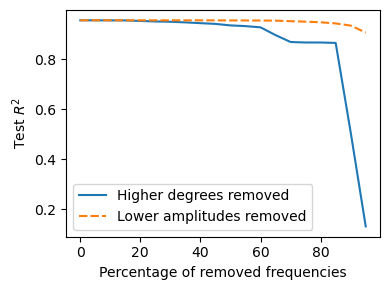

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.lineplot(pd.DataFrame.from_dict(results).set_index("Percentage of removed frequencies"), ax=ax)
ax.set_ylabel("Test $R^2$")
ax.legend(loc='lower left').set_zorder(102)
fig.tight_layout()
plt.savefig(f"plots/files/ablation/{model_name}.pdf")